# Cryptocurrency Price Forecasting

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
import scipy.special as sc
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('all_currencies.csv',parse_dates=['Date'], index_col='Date',
               date_parser=dateparse)
df=pd.read_csv('all_currencies.csv')
df= df.assign(Date = pd.to_datetime(df['Date']))
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [3]:
df.tail()

,Date,Symbol,Open,High,Low,Close,Volume,Market Cap
632213,2018-09-23,ZZC,0.067149,0.067324,0.024069,0.024161,34.0,130705.0
632214,2018-09-24,ZZC,0.024167,0.091875,0.024121,0.091631,58.0,47041.0
632215,2018-09-25,ZZC,0.091528,0.091568,0.057507,0.090547,752.0,178158.0
632216,2018-09-26,ZZC,0.090400,0.104745,0.086071,0.086559,60.0,175963.0
632217,2018-09-27,ZZC,0.086664,0.130541,0.067363,0.073475,91.0,168691.0


In [4]:
df.dtypes

Date          datetime64[ns]
Symbol                object
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Market Cap           float64
dtype: object

# Bitcoin

In [5]:
df_btc = df[df['Symbol']=='BTC']

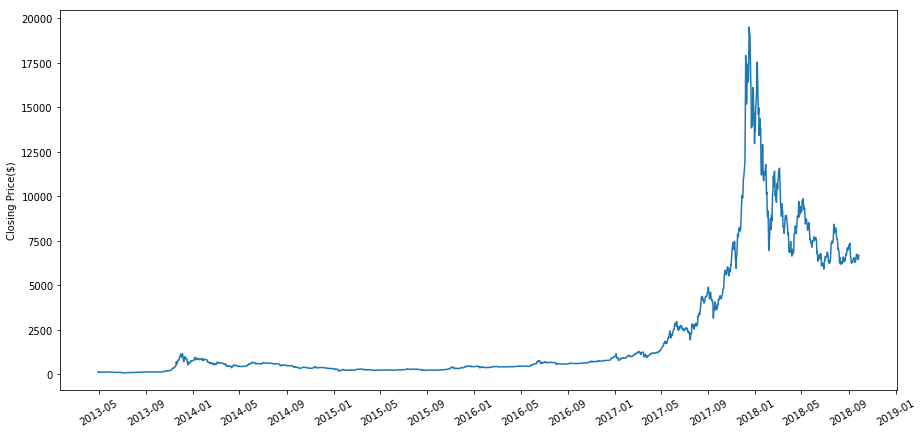

In [6]:
fig, ax = plt.subplots(figsize=(15,7))

plt.plot(df_btc['Date'],df_btc['Close'])
plt.ylabel('Closing Price($)')
majorFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,5,9]))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)
plt.show()


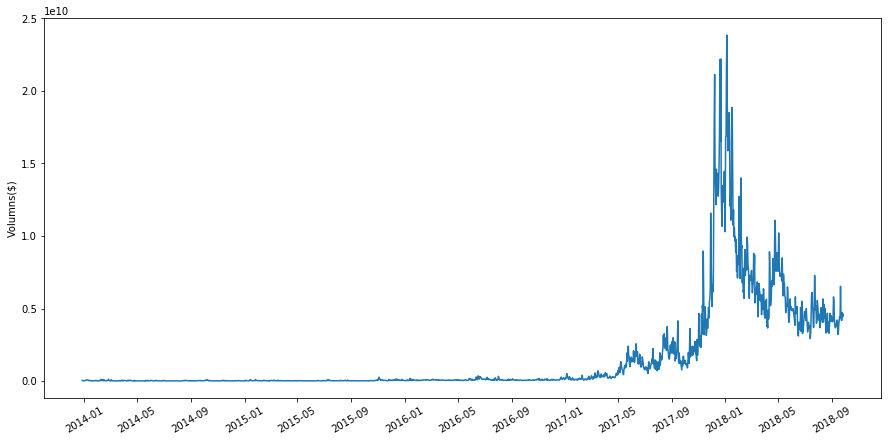

In [7]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(df_btc['Date'], df_btc['Volume'])
plt.ylabel('Volumns($)')
majorFmt = mdates.DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,5,9]))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)

plt.show()

# AR, MA & ARMA

In [34]:
#import package for ARIMA 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Check stationarity 

A stationary time seires is one whose mean is constant over time and covaraince  cov($X_t,X_{t+h})$ does not depend on t.

We need to make sure that the time series data is stationary to use the ARMA model.

In [30]:
df_btc = df_btc.set_index('Date')

In [10]:
df_btc.head()

,Symbol,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2013-04-28,BTC,135.30,135.98,132.10,134.21,NaN,1.500520e+09
2013-04-29,BTC,134.44,147.49,134.00,144.54,NaN,1.491160e+09
2013-04-30,BTC,144.00,146.93,134.05,139.00,NaN,1.597780e+09
2013-05-01,BTC,139.00,139.89,107.72,116.99,NaN,1.542820e+09
2013-05-02,BTC,116.38,125.60,92.28,105.21,NaN,1.292190e+09


In [31]:
print('First day record : {}'.format(df_btc.index[0]))
print('Last day record: {}'.format(df_btc.index[-1]))

First day record : 2013-04-28 00:00:00
Last day record: 2018-09-27 00:00:00


In [32]:
# Resampling to monthly frequency
btc_month = df_btc.resample('M').mean()

In [33]:
btc_month.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-30,137.913333,143.466667,133.383333,139.250000,NaN,1.529820e+09
2013-05-31,120.292258,123.948710,114.253226,119.992581,NaN,1.342523e+09
2013-06-30,108.856667,111.300667,104.602000,107.761333,NaN,1.228664e+09
2013-07-31,90.311290,93.869032,86.719677,90.512258,NaN,1.031498e+09
2013-08-31,113.041935,116.002258,111.387742,113.905161,NaN,1.306910e+09


By Wikipedia: In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

In [14]:
series = btc_month.Close
X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.147333
p-value: 0.695832
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591


The null hypothesis in the test is: this series of data is non-stationary. \\
And the statistic value is greater than the all the critical values that are listed, which means that the null hypothesis cannot be rejected by these confidence levels. We should consider this series is not stationary. 

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

Dickey–Fuller test: p=0.695832


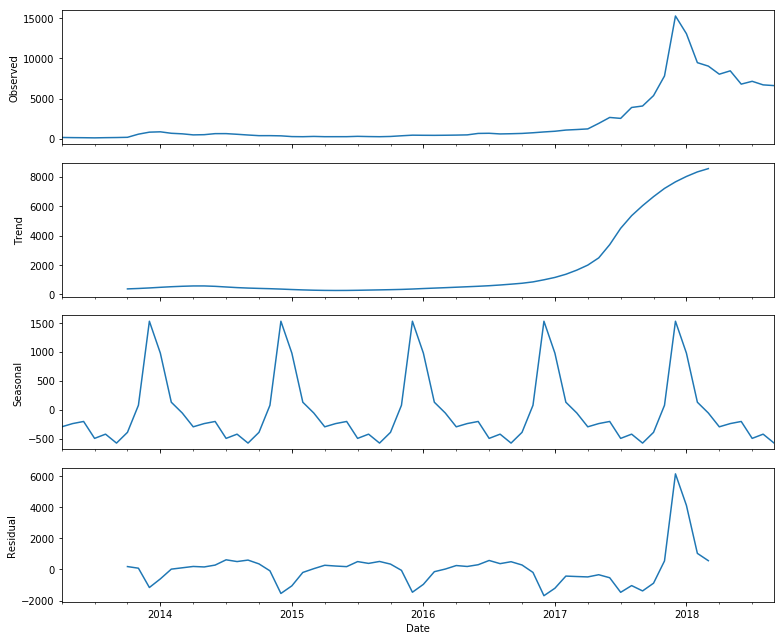

In [16]:
seasonal_decompose(btc_month.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])
plt.show()

The p-value indicates that series is not stationary with 69.58% confidence

We observed that the bitcoin price is somewhat stable before 2017, but experienced an amazing growth in the end of 2017, and then crashed a certain amount in 2018.

However the residual in the plot has a very obvious seasonal trend. This data need some transformation.

In [17]:
def init_boxcox(data):
    from scipy.special import inv_boxcox as inverse
    from scipy.stats import boxcox as forward
    lambdas = dict()

    def myforward(data):
        transformed, lambdas[data.name] = forward(1 + data)
        if lambdas[data.name]<0:
            lambdas[data.name]=0
        transformed=np.log1p(data)
        return transformed

    def myinverse(data):
        if lambdas[data.name]==0:
            return np.expm1(data)
        else:
            transformed = inverse(data, lambdas[data.name])-1
        return transformed

    return myforward(data), myinverse(data)

In [18]:
from scipy.special import boxcox1p

In [19]:
lmd_values = [0.1, 0.25, 0.5, 1, 2, 3, 3.2, 3.5]
for lmd in lmd_values:
    boxcox_x = boxcox1p(btc_month.Close, lmd)
    print("Dickey–Fuller test: p=%f" % adfuller(boxcox_x)[1])

Dickey–Fuller test: p=0.807421
Dickey–Fuller test: p=0.845444
Dickey–Fuller test: p=0.825181
Dickey–Fuller test: p=0.695832
Dickey–Fuller test: p=0.083645
Dickey–Fuller test: p=0.003461
Dickey–Fuller test: p=0.001849
Dickey–Fuller test: p=1.000000


We can see with the lambda value as 3.2, the p value indicates that the process becomes more stationary than the original one. 

Dickey–Fuller test: p=0.793401


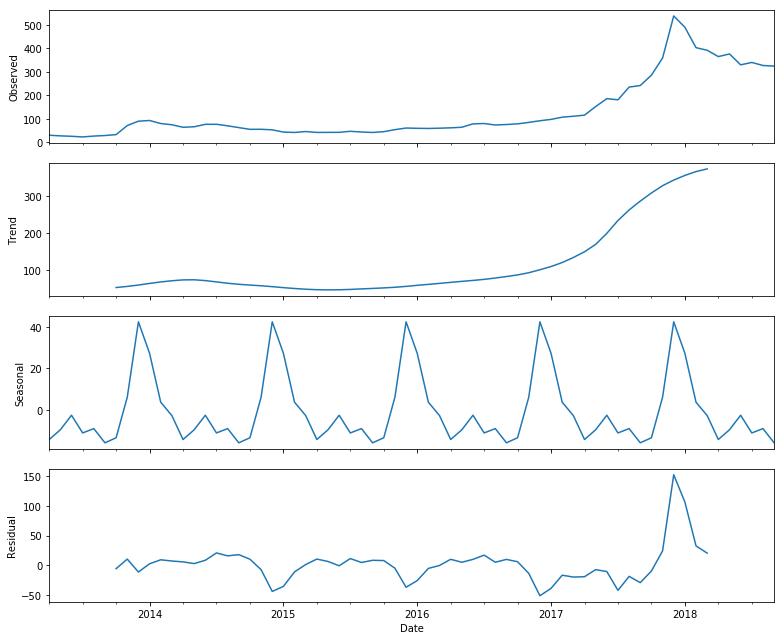

In [77]:
lmbda = 0.6
btc_month['box_cox'] = boxcox1p(btc_month.Close, lmbda)
seasonal_decompose(btc_month.box_cox).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_cox)[1])
plt.show()

## Differencing

We need to use differencing method to make the series data stationary.


In [78]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.box_cox - btc_month.box_cox.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.940636


In [79]:
# Seasonal differentiation (6 months)
btc_month['box_diff_seasonal_6'] = btc_month.box_cox - btc_month.box_cox.shift(6)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_6[6:])[1])

Dickey–Fuller test: p=0.599853


In [80]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.box_cox - btc_month.box_cox.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.014911


In [81]:
# Seasonal differentiation (1 months)
btc_month['box_diff_seasonal_1'] = btc_month.box_cox - btc_month.box_cox.shift(1)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_1[1:])[1])

Dickey–Fuller test: p=0.000000


### Regular differentiation
sometimes it makes sense that some of the seasonality needs to be catched by the second order differencing. 

Dickey–Fuller test: p=0.004854


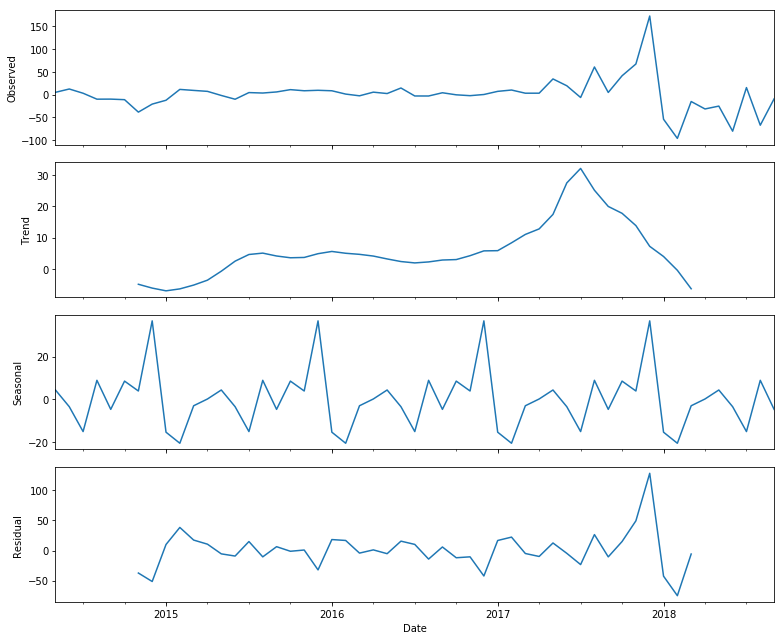

In [82]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])
plt.show()

This result indicates that the second order of differencing works better than the original one in terms of the staionary. And the residual plot has less pattern than before. 

## ACF - 12 months first order

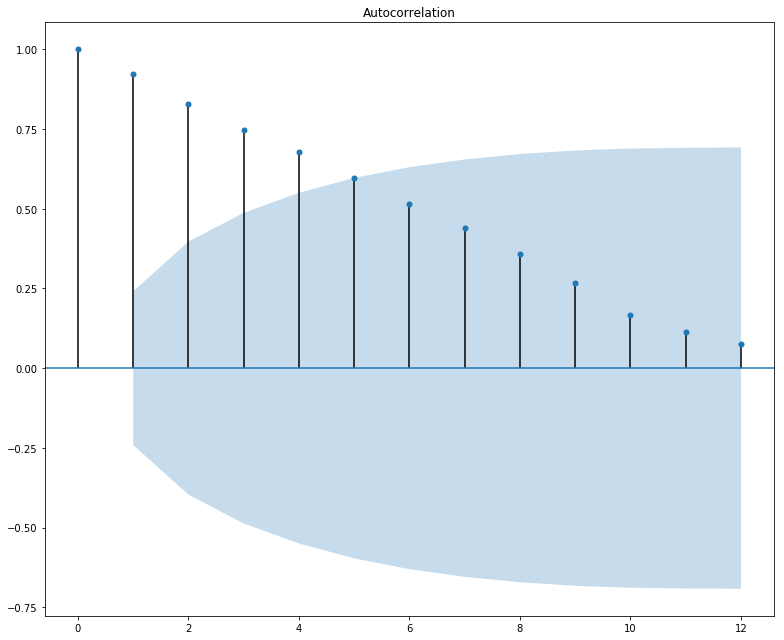

In [83]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.Close.values.squeeze(), lags=12)
plt.tight_layout()
plt.show()

## PACF

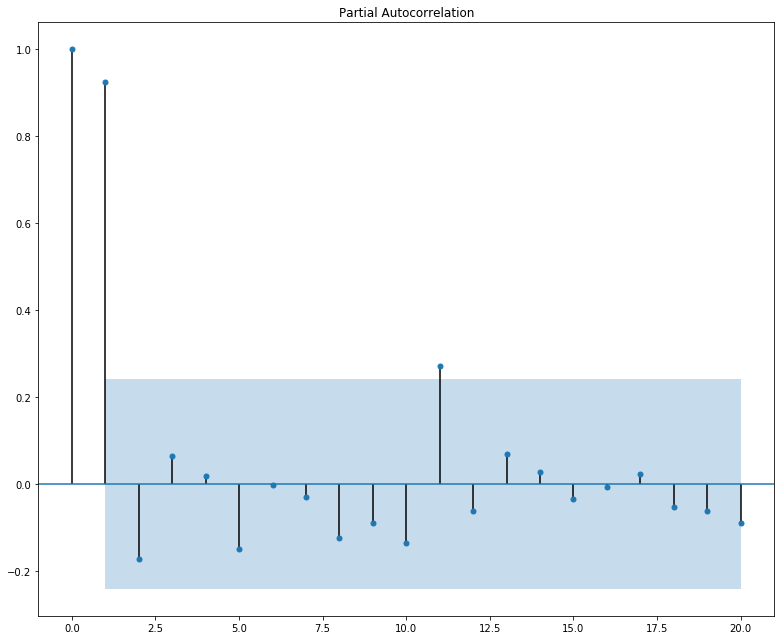

In [84]:
plot_pacf(btc_month.Close.values.squeeze(), lags=20)
plt.tight_layout()
plt.show()

The partial autocorrelation plot displays no spikes outside the significance interval, which means that there probably no enough information to be drawn by the autoregression model. 
AR(1) component

## ACF - 12 months second order

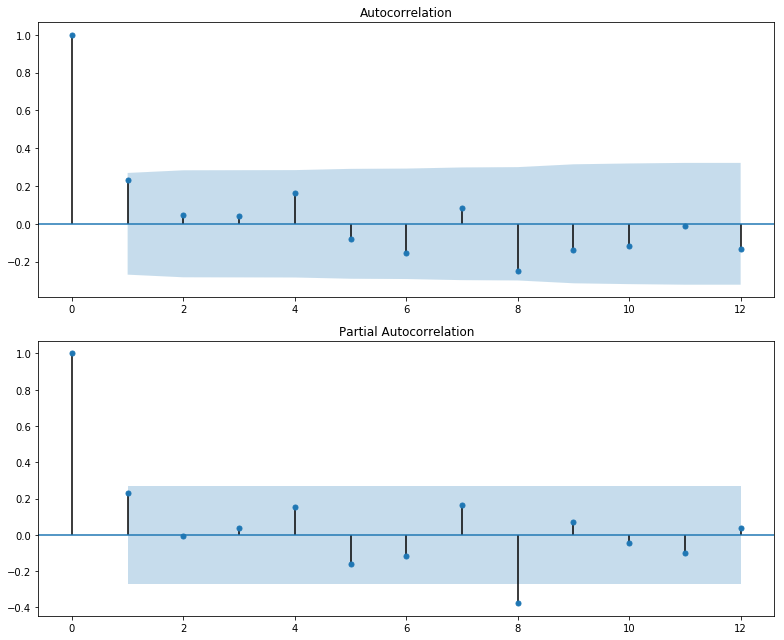

In [85]:
ax = plt.subplot(211)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

This 12 months second order ACF and PACF plots suggest that this trend may be captured by an autoregression time series model AR(8)

In [86]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot 

In [87]:
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(btc_month.box_diff2[13:].values):
    X_train, X_test = btc_month.box_diff2[13:].values[train_index], btc_month.box_diff2[13:].values[test_index]
    ar = AR(X_train)
    model_ar = ar.fit(maxlag=8)
    pred = model_ar.predict(start=len(X_train), end=len(X_train)+len(X_test)-1, dynamic=False)
    error = mean_squared_error(X_test, pred)
    print('Test MSE: %.3f' % error)

Test MSE: 78.693
Test MSE: 91.180
Test MSE: 145.071
Test MSE: 4952.472
Test MSE: 189869.545


AR model is too simple that cannot capture a complex trend like this. Let's try ARIMA model next:

In [88]:
# log transformation
btc_close_log = np.log(df_btc.Close.values)
result = adfuller(btc_close_log)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.806608
p-value: 0.817173
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [89]:
# differencing
ts_log_diff =np.diff(btc_close_log)
result = adfuller(ts_log_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.150787
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


## ARIMA

In [90]:
from itertools import product
import warnings

In [91]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = ARIMA(btc_close_log, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

bad parameter combination: (1, 1)
bad parameter combination: (1, 2)


In [92]:
best_param

(2, 2)

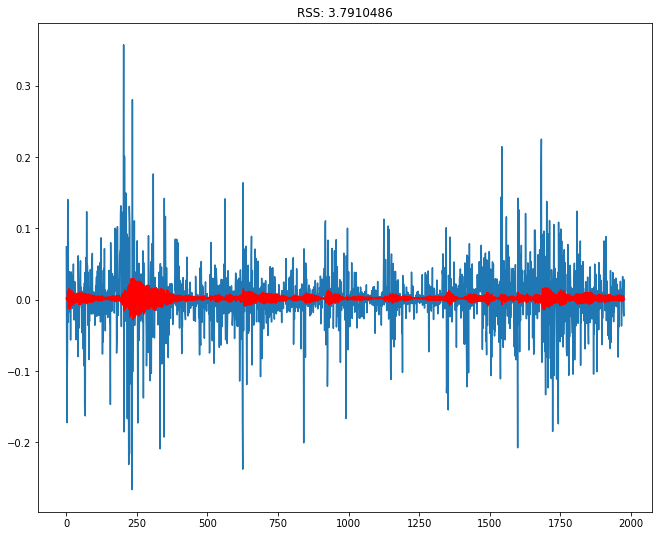

In [93]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(btc_close_log, order=(2,1,2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

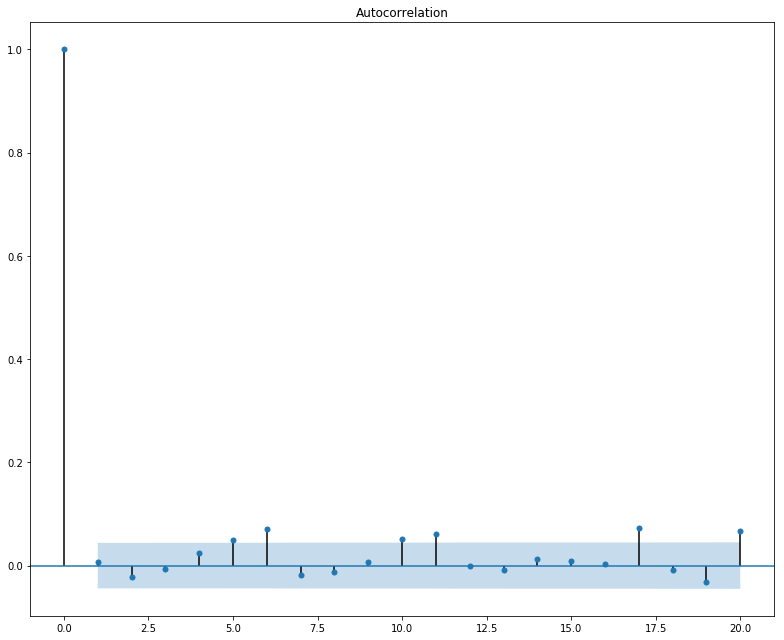

In [112]:
plot_acf(ts_log_diff, lags=20)
plt.tight_layout()
plt.show()

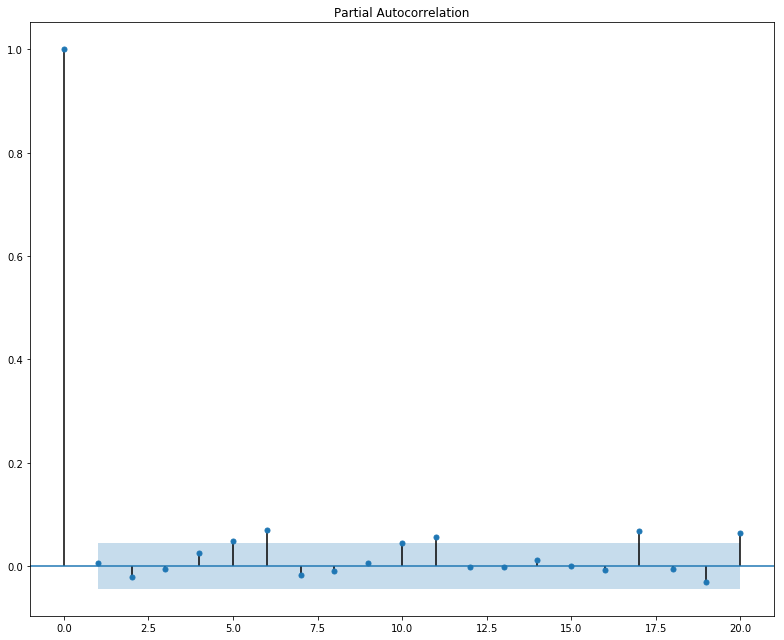

In [111]:
plot_pacf(ts_log_diff, lags=20)
plt.tight_layout()
plt.show()

In [94]:
size = int(len(btc_close_log)-100)
# Divide into train and test
train_arima, test_arima = btc_close_log[0:size], btc_close_log[size:len(btc_close_log)]
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, order=(1, 2, 2))
    model_fit = model.fit(disp=-1)
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = test_arima[t]
    history.append(original_value)
    
    pred_value = np.exp(pred_value)
    
    
    original_value = np.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plt.figure(figsize=(8, 6))
test_day = [t
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plt.plot(test_day, predictions, color= 'green')
plt.plot(test_day, originals, color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend(labels)
plt.show()

Printing Predicted vs Expected Values...


predicted = 6788.463181,   expected = 6776.550000,   error = 0.175800  %
predicted = 6780.514416,   expected = 6729.740000,   error = 0.754478  %
predicted = 6731.962123,   expected = 6083.690000,   error = 10.655903  %
predicted = 6075.742371,   expected = 6162.480000,   error = 1.407512  %
predicted = 6161.084091,   expected = 6173.230000,   error = 0.196751  %


KeyboardInterrupt: 

## SARIMA

In [95]:
from itertools import product
import warnings

In [96]:
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.box_cox, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

bad parameter combination: (0, 0)


In [97]:
best_aic

629.6092026073417

In [98]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
0     (0, 1)  629.609203
2     (1, 0)  629.955524
5     (2, 0)  631.455697
1     (0, 2)  631.601614
3     (1, 1)  631.604615


In [99]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


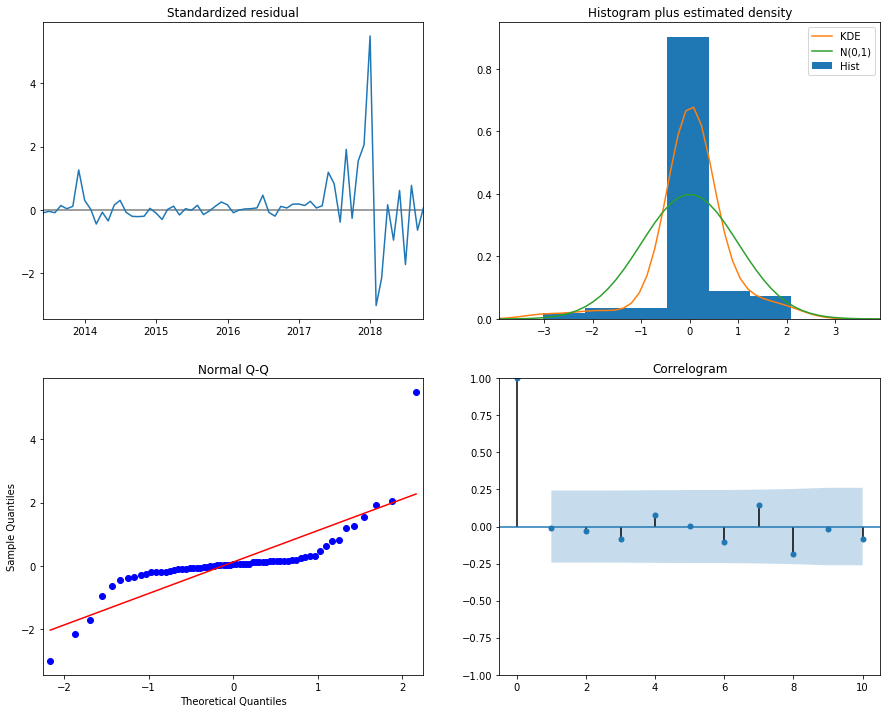

In [100]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [101]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [102]:
btc_month.tail()

,Open,High,Low,Close,Volume,Market Cap,box_cox,box_diff_seasonal_12,box_diff_seasonal_6,box_diff_seasonal_3,box_diff_seasonal_1,box_diff2
Date,,,,,,,,,,,,
2018-05-31,8505.240645,8638.820000,8283.560645,8450.997742,6.374571e+09,1.448831e+11,376.797157,224.079053,17.405610,-26.803232,11.327633,-25.293433
2018-06-30,6829.258000,6930.069000,6670.762667,6793.507667,4.340473e+09,1.167378e+11,330.337509,143.840833,-208.231245,-62.085164,-46.459649,-80.238220
2018-07-31,7101.466452,7258.952581,6982.127419,7146.350000,4.562643e+09,1.218138e+11,340.577283,159.125403,-149.732157,-24.892241,10.239775,15.284570
2018-08-31,6723.800968,6849.496129,6580.563548,6700.130000,4.267509e+09,1.157262e+11,327.592273,91.967869,-76.008116,-49.204884,-12.985010,-67.157534
2018-09-30,6620.669630,6711.180000,6516.843704,6609.207407,4.309814e+09,1.143120e+11,324.904473,82.599870,-67.518200,-5.433036,-2.687800,-9.367998


In [109]:
datetime.datetime.strptime(datetime.date(2018, 6, 30), '%m/%d/%Y')

TypeError: strptime() argument 1 must be str, not datetime.date

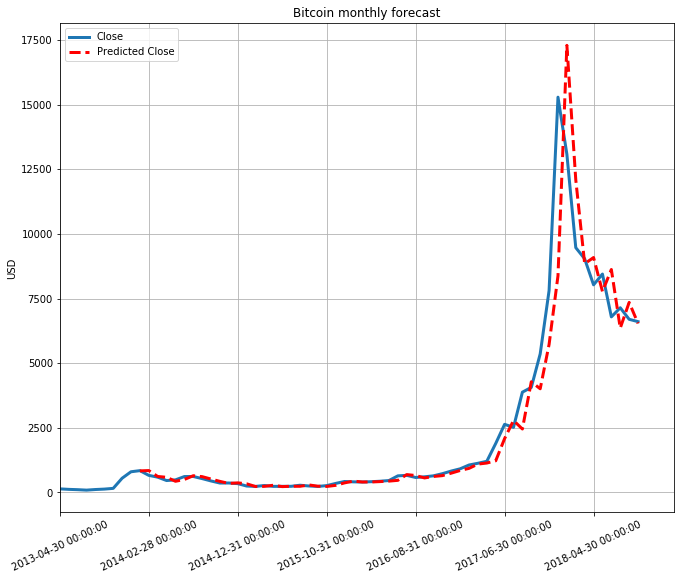

In [114]:
btc_month_pred = btc_month[['Close']]
date_list = [datetime.date(2018, 6, 30), datetime.date(2018, 7, 31), datetime.date(2018, 8, 31), datetime.date(2018, 9, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

btc_month_pred['forecast'] = invboxcox(best_model.predict(start='2014-1-31', end='2018-9-30'), lmbda)

btc_month_pred.Close.plot(linewidth=3)
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.xticks(rotation=25)
plt.show()

### RNN

In [197]:
df_btc.head()

,Date,Symbol,Open,High,Low,Close,Volume,Market Cap
88595,2013-04-28,BTC,135.30,135.98,132.10,134.21,NaN,1.500520e+09
88596,2013-04-29,BTC,134.44,147.49,134.00,144.54,NaN,1.491160e+09
88597,2013-04-30,BTC,144.00,146.93,134.05,139.00,NaN,1.597780e+09
88598,2013-05-01,BTC,139.00,139.89,107.72,116.99,NaN,1.542820e+09
88599,2013-05-02,BTC,116.38,125.60,92.28,105.21,NaN,1.292190e+09


In [196]:
df_btc.Close.iloc[0]

134.21

In [211]:
#split train test dataset
split_value = int(len(df_btc.Close)*.2)
df_train= df_btc.Close.values[:len(df_btc.Close)-split_value]
df_test= df_btc.Close.values[len(df_btc.Close)-split_value:]

In [11]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(df_train.reshape(-1, 1))
test_set = sc.transform(df_test.reshape(-1,1))
#cross-validation using the fixed slide size
def preparation_data(window_size, training_set, test_set):
    X_train_slide = []
    y_train = []
    X_test_slide = []
    y_test = []
    for i in range(len(training_set)-window_size):
        X_train_slide.append(training_set[i:i+window_size])
        y_train.append(float(training_set[i+window_size]))
    for i in range(len(test_set)-window_size):
        X_test_slide.append(test_set[i:i+window_size])
        y_test.append(df_test[i+window_size])

    #normalize and reshape to feed into neural network
    X_train = np.reshape(X_train_slide, (len(X_train_slide),1, window_size))
    X_test = np.reshape(X_test_slide, (len(X_test_slide), 1, window_size)) 
    return X_train, y_train, X_test, y_test

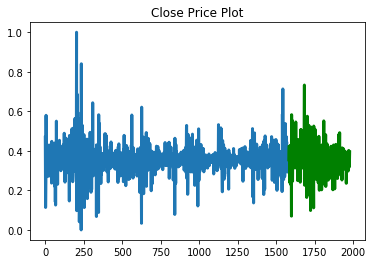

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_set)), training_set, linewidth=3)
plt.plot(range(len(training_set), len(training_set)+len(test_set)), test_set, c = 'green', linewidth=3)
plt.title('Close Price Plot')
plt.show()

In [13]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [14]:
#window size is 10
window_size=10
X_train, y_train, X_test, y_test = preparation_data(window_size, training_set, test_set)
learning_rate = 0.001
num_epoch = 100
batch_size = 1
# callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

regressor = Sequential()
regressor.add(LSTM(units = 20, activation = 'sigmoid', batch_input_shape = (batch_size, 1, window_size), return_sequences=False))
regressor.add(Dense(units = 1))
# adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epoch, shuffle=False)
loss_history = history.history["loss"]

KeyboardInterrupt: 

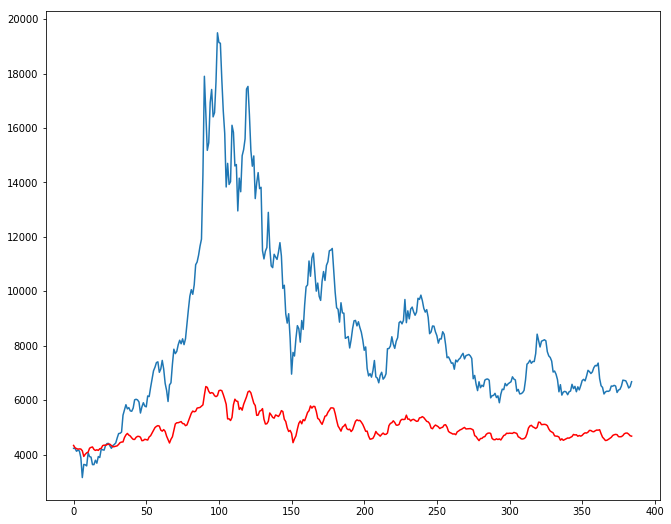

In [166]:
predicted_BTC_price = regressor.predict(X_test, batch_size=batch_size)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
plt.plot(y_test)
plt.plot(predicted_BTC_price, 'r')
plt.show()

Epoch 1/100
1581/1581 [==============================] - 4s 3ms/step - loss: 3.2970e-04
Epoch 2/100
1581/1581 [==============================] - 3s 2ms/step - loss: 0.0034
Epoch 3/100
1581/1581 [==============================] - 3s 2ms/step - loss: 0.0016
Epoch 4/100
1581/1581 [==============================] - 3s 2ms/step - loss: 8.0359e-04
Epoch 5/100
1581/1581 [==============================] - 3s 2ms/step - loss: 5.3439e-04
Epoch 6/100
1581/1581 [==============================] - 3s 2ms/step - loss: 4.3417e-04
Epoch 7/100
1581/1581 [==============================] - 3s 2ms/step - loss: 3.8597e-04
Epoch 8/100
1581/1581 [==============================] - 3s 2ms/step - loss: 3.5837e-04
Epoch 9/100
1581/1581 [==============================] - 3s 2ms/step - loss: 3.4040e-04
Epoch 10/100
1581/1581 [==============================] - 3s 2ms/step - loss: 3.2748e-04
Epoch 11/100
1581/1581 [==============================] - 3s 2ms/step - loss: 3.1772e-04
Epoch 12/100
1581/1581 [==============

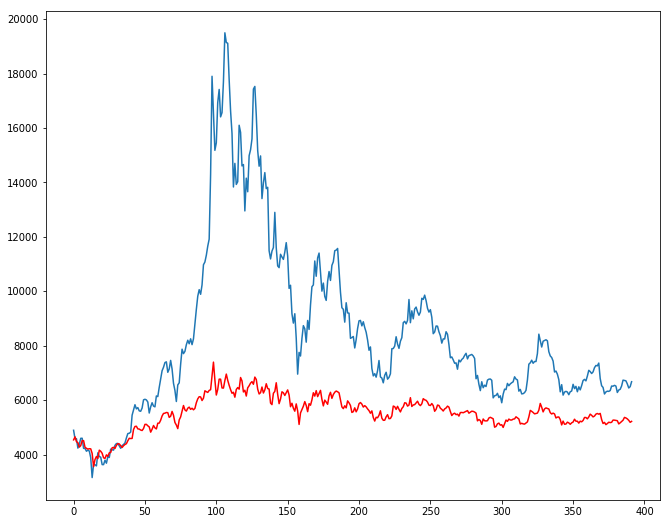

In [170]:
#window size = 3
window_size=3
X_train, y_train, X_test, y_test = preparation_data(window_size, training_set, test_set)

learning_rate = 0.001
num_epoch = 100
batch_size = 1
# callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

regressor = Sequential()
regressor.add(LSTM(units = 20, activation = 'sigmoid', batch_input_shape = (batch_size, 1, window_size), return_sequences=False))
regressor.add(Dense(units = 1))
# adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epoch, shuffle=False)
loss_history = history.history["loss"]

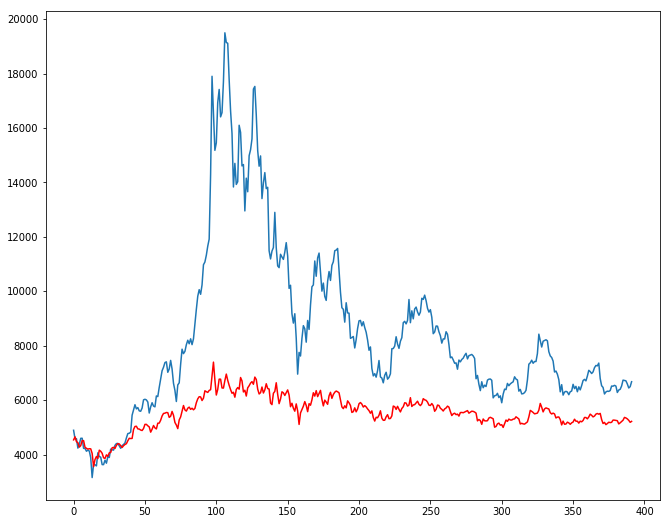

In [171]:
predicted_BTC_price = regressor.predict(X_test, batch_size=batch_size)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
plt.plot(y_test)
plt.plot(predicted_BTC_price, 'r')
plt.show()

In [174]:
#window_size = 1
window_size=1
X_train, y_train, X_test, y_test = preparation_data(window_size, training_set, test_set)

learning_rate = 0.001
num_epoch = 100
batch_size = 1
# callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

regressor = Sequential()
regressor.add(LSTM(units = 20, activation = 'sigmoid', batch_input_shape = (batch_size, 1, window_size), return_sequences=False))
regressor.add(Dense(units = 1))
# adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epoch, shuffle=False)
loss_history = history.history["loss"]

Epoch 1/100
1583/1583 [==============================] - 5s 3ms/step - loss: 7.6366e-04
Epoch 2/100
1583/1583 [==============================] - 3s 2ms/step - loss: 0.0040
Epoch 3/100
1583/1583 [==============================] - 3s 2ms/step - loss: 0.0028
Epoch 4/100
1583/1583 [==============================] - 3s 2ms/step - loss: 0.0017
Epoch 5/100
1583/1583 [==============================] - 3s 2ms/step - loss: 9.8916e-04
Epoch 6/100
1583/1583 [==============================] - 3s 2ms/step - loss: 6.4107e-04
Epoch 7/100
1583/1583 [==============================] - 3s 2ms/step - loss: 4.7061e-04
Epoch 8/100
1583/1583 [==============================] - 3s 2ms/step - loss: 3.8247e-04
Epoch 9/100
1583/1583 [==============================] - 3s 2ms/step - loss: 3.3132e-04
Epoch 10/100
1583/1583 [==============================] - ETA: 0s - loss: 2.7701e-0 - 3s 2ms/step - loss: 2.9858e-04
Epoch 11/100
1583/1583 [==============================] - 3s 2ms/step - loss: 2.7617e-04
Epoch 12/100
1

Epoch 93/100
1583/1583 [==============================] - 3s 2ms/step - loss: 1.6672e-04
Epoch 94/100
1583/1583 [==============================] - 3s 2ms/step - loss: 1.6550e-04
Epoch 95/100
1583/1583 [==============================] - 4s 3ms/step - loss: 1.6445e-04
Epoch 96/100
1583/1583 [==============================] - 4s 3ms/step - loss: 1.6348e-04
Epoch 97/100
1583/1583 [==============================] - 3s 2ms/step - loss: 1.6267e-04
Epoch 98/100
1583/1583 [==============================] - 4s 2ms/step - loss: 1.6189e-04
Epoch 99/100
1583/1583 [==============================] - 4s 2ms/step - loss: 1.6121e-04
Epoch 100/100
1583/1583 [==============================] - 3s 2ms/step - loss: 1.6051e-04


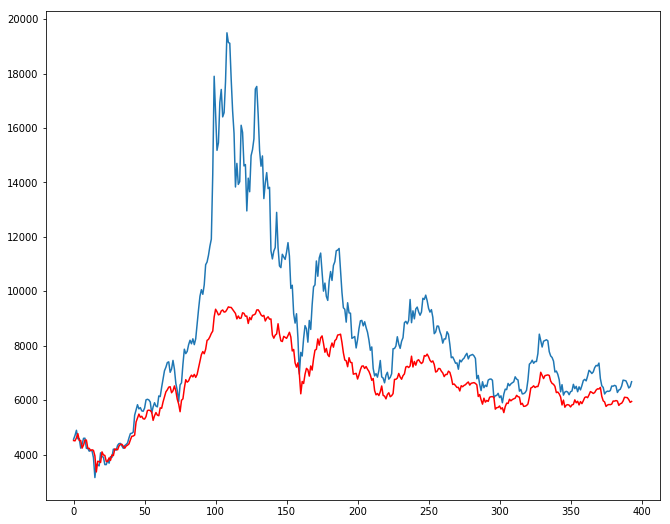

In [175]:
predicted_BTC_price = regressor.predict(X_test, batch_size=batch_size)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
plt.plot(y_test)
plt.plot(predicted_BTC_price, 'r')
plt.show()

In [184]:
#tune parameter
learning_rate = 0.001
num_epoch = 500
batch_size = 32
# callbacks = [EarlyStopping(monitor='val_loss', patience=2),
#              ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
regressor = Sequential()
regressor.add(LSTM(units = 20, activation = 'sigmoid', input_shape = (1, window_size), return_sequences=False))
regressor.add(Dense(units = 1))
# adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epoch, shuffle=False)
loss_history = history.history["loss"]

Epoch 1/500
1583/1583 [==============================] - 3s 2ms/step - loss: 0.0404
Epoch 2/500
1583/1583 [==============================] - 0s 101us/step - loss: 0.0243
Epoch 3/500
1583/1583 [==============================] - 0s 114us/step - loss: 0.0245
Epoch 4/500
1583/1583 [==============================] - 0s 112us/step - loss: 0.0239
Epoch 5/500
1583/1583 [==============================] - 0s 119us/step - loss: 0.0235
Epoch 6/500
1583/1583 [==============================] - 0s 115us/step - loss: 0.0231
Epoch 7/500
1583/1583 [==============================] - 0s 80us/step - loss: 0.0227
Epoch 8/500
1583/1583 [==============================] - 0s 87us/step - loss: 0.0223
Epoch 9/500
1583/1583 [==============================] - 0s 79us/step - loss: 0.0218
Epoch 10/500
1583/1583 [==============================] - 0s 88us/step - loss: 0.0214
Epoch 11/500
1583/1583 [==============================] - 0s 80us/step - loss: 0.0210
Epoch 12/500
1583/1583 [==============================] - 0

Epoch 95/500
1583/1583 [==============================] - 0s 89us/step - loss: 1.1790e-04
Epoch 96/500
1583/1583 [==============================] - 0s 133us/step - loss: 1.1301e-04 0s - loss: 6.0867e-
Epoch 97/500
1583/1583 [==============================] - 0s 115us/step - loss: 1.0899e-04
Epoch 98/500
1583/1583 [==============================] - 0s 93us/step - loss: 1.0570e-04
Epoch 99/500
1583/1583 [==============================] - 0s 121us/step - loss: 1.0302e-04
Epoch 100/500
1583/1583 [==============================] - 0s 151us/step - loss: 1.0085e-04
Epoch 101/500
1583/1583 [==============================] - 0s 132us/step - loss: 9.9082e-05
Epoch 102/500
1583/1583 [==============================] - 0s 126us/step - loss: 9.7658e-05
Epoch 103/500
1583/1583 [==============================] - 0s 146us/step - loss: 9.6510e-05
Epoch 104/500
1583/1583 [==============================] - 0s 141us/step - loss: 9.5586e-05
Epoch 105/500
1583/1583 [==============================] - 0s 104us

Epoch 184/500
1583/1583 [==============================] - 0s 80us/step - loss: 9.2341e-05
Epoch 185/500
1583/1583 [==============================] - 0s 85us/step - loss: 9.2386e-05
Epoch 186/500
1583/1583 [==============================] - 0s 82us/step - loss: 9.2430e-05
Epoch 187/500
1583/1583 [==============================] - 0s 78us/step - loss: 9.2472e-05
Epoch 188/500
1583/1583 [==============================] - 0s 78us/step - loss: 9.2511e-05
Epoch 189/500
1583/1583 [==============================] - 0s 82us/step - loss: 9.2547e-05
Epoch 190/500
1583/1583 [==============================] - 0s 79us/step - loss: 9.2579e-05
Epoch 191/500
1583/1583 [==============================] - 0s 79us/step - loss: 9.2608e-05
Epoch 192/500
1583/1583 [==============================] - 0s 79us/step - loss: 9.2635e-05
Epoch 193/500
1583/1583 [==============================] - 0s 79us/step - loss: 9.2661e-05
Epoch 194/500
1583/1583 [==============================] - 0s 79us/step - loss: 9.2687e-05

1583/1583 [==============================] - 0s 79us/step - loss: 9.3302e-05
Epoch 363/500
1583/1583 [==============================] - 0s 80us/step - loss: 9.3299e-05
Epoch 364/500
1583/1583 [==============================] - 0s 81us/step - loss: 9.3296e-05
Epoch 365/500
1583/1583 [==============================] - 0s 79us/step - loss: 9.3293e-05
Epoch 366/500
1583/1583 [==============================] - 0s 80us/step - loss: 9.3290e-05
Epoch 367/500
1583/1583 [==============================] - 0s 79us/step - loss: 9.3287e-05
Epoch 368/500
1583/1583 [==============================] - 0s 81us/step - loss: 9.3285e-05
Epoch 369/500
1583/1583 [==============================] - 0s 79us/step - loss: 9.3282e-05
Epoch 370/500
1583/1583 [==============================] - 0s 79us/step - loss: 9.3279e-05
Epoch 371/500
1583/1583 [==============================] - 0s 80us/step - loss: 9.3277e-05
Epoch 372/500
1583/1583 [==============================] - 0s 80us/step - loss: 9.3274e-05
Epoch 373/500

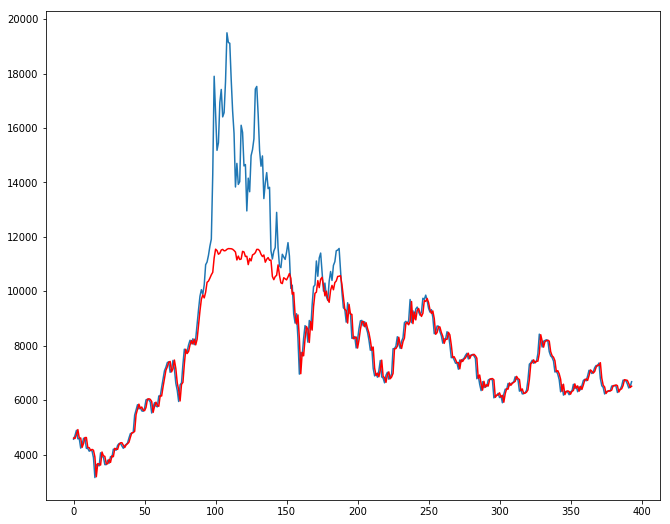

In [185]:
predicted_BTC_price = regressor.predict(X_test, batch_size=batch_size)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
plt.plot(y_test)
plt.plot(predicted_BTC_price, 'r')
plt.show()

In [186]:
# rmse
print('The RMSE is: %s'%sqrt(mean_squared_error(y_test, predicted_BTC_price)))

The RMSE is: 1528.3053404197233


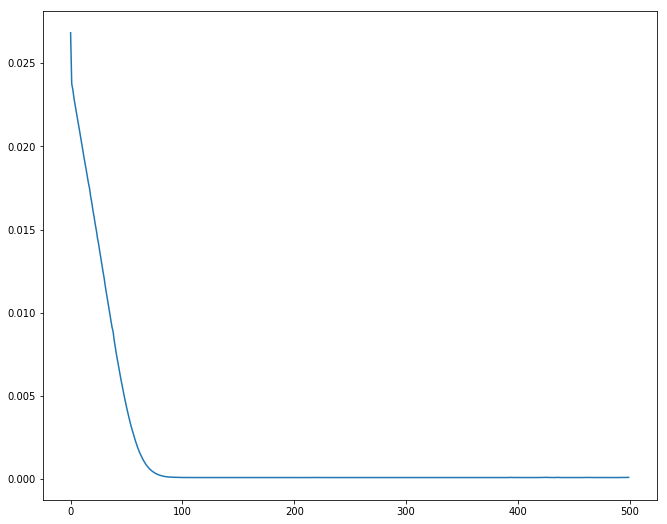

In [137]:
plt.plot(loss_history)
plt.show()

### Ratio

In [9]:
close_price = df_btc.Close.values
close_ratio = []
for i in range(len(close_price)-1):
    close_ratio.append((close_price[i+1]-close_price[i])/close_price[i]*1.0)

In [15]:
split_value_ratio = int(len(close_ratio)*.2)
df_train= np.array(close_ratio[:len(close_ratio)-split_value_ratio])
df_test= np.array(close_ratio[len(close_ratio)-split_value_ratio:])
training_set_ratio = sc.fit_transform(df_train.reshape(-1, 1))
test_set_ratio = sc.transform(df_test.reshape(-1,1))

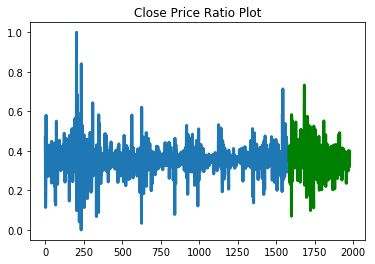

In [16]:
plt.plot(range(len(training_set_ratio)), training_set_ratio, linewidth=3)
plt.plot(range(len(training_set_ratio), len(training_set_ratio)+len(test_set_ratio)), test_set_ratio, c = 'green', linewidth=3)
plt.title('Close Price Ratio Plot')
plt.show()

In [2]:
#window size = 3
window_size=100
X_train, y_train, X_test, y_test = preparation_data(window_size, training_set_ratio, test_set_ratio)

learning_rate = 0.0001
num_epoch = 10
batch_size = 1
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
regressor = Sequential()
regressor.add(LSTM(units = 206, activation = 'sigmoid', batch_input_shape = (batch_size, 1, window_size), return_sequences=False))
regressor.add(Dense(units = 1))
# adam = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', )
history = regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epoch, shuffle=False, callbacks=callbacks)
loss_history = history.history["loss"]

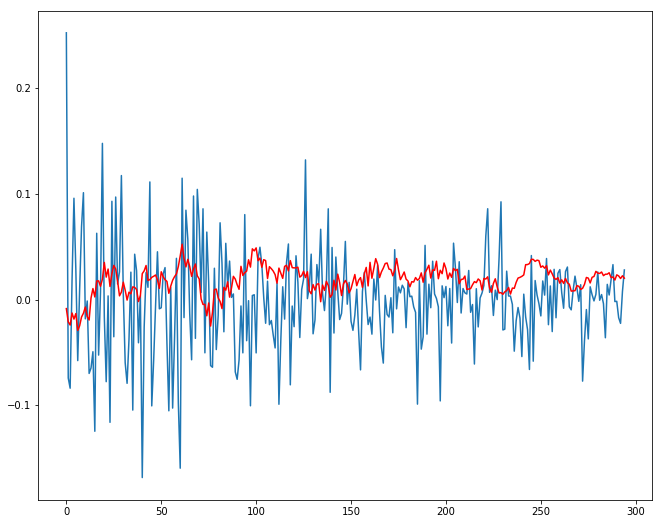

In [229]:
predicted_BTC_price = regressor.predict(X_test, batch_size=batch_size)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
plt.plot(y_test)
plt.plot(predicted_BTC_price, 'r')
plt.show()

In [17]:
from arch import arch_model
train = list(training_set_ratio.reshape(1, -1)[0])
test = list(test_set_ratio.reshape(1, -1)[0])
# define model
model = arch_model(train, mean='Zero', vol='GARCH', p=1, q=1)
# fit model
model_fit = model.fit()
# forecast the test set
forecasts = model_fit.forecast(horizon=split_value_ratio)
#[split_value_ratio:]
y_hat = forecasts.mean

Iteration:      1,   Func. Count:      5,   Neg. LLF: 640.0374625170755
Iteration:      2,   Func. Count:     15,   Neg. LLF: 640.0329975925796
Iteration:      3,   Func. Count:     24,   Neg. LLF: 640.0111623410457
Iteration:      4,   Func. Count:     30,   Neg. LLF: 639.872671903051
Iteration:      5,   Func. Count:     36,   Neg. LLF: 639.8293964906575
Iteration:      6,   Func. Count:     42,   Neg. LLF: 639.8127220189663
Iteration:      7,   Func. Count:     48,   Neg. LLF: 639.8051628798651
Iteration:      8,   Func. Count:     53,   Neg. LLF: 639.8048389628404
Iteration:      9,   Func. Count:     58,   Neg. LLF: 639.8048098624652
Iteration:     10,   Func. Count:     63,   Neg. LLF: 639.8048017202971
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 639.80480146369
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10


In [303]:
len(train)

1583

In [251]:
print(model_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -639.805
Distribution:                  Normal   AIC:                           1285.61
Method:            Maximum Likelihood   BIC:                           1301.71
                                        No. Observations:                 1583
Date:                Tue, Dec 04 2018   Df Residuals:                     1580
Time:                        20:38:36   Df Model:                            3
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      2.6896e-03  2.185e-03      1.231      0.218 

In [315]:
y_hat*100

array([0.36028157, 0.35870546, 0.35436544, ..., 0.3714769 , 0.37107602,
       0.37041381])

In [316]:
y_hat = np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]'])

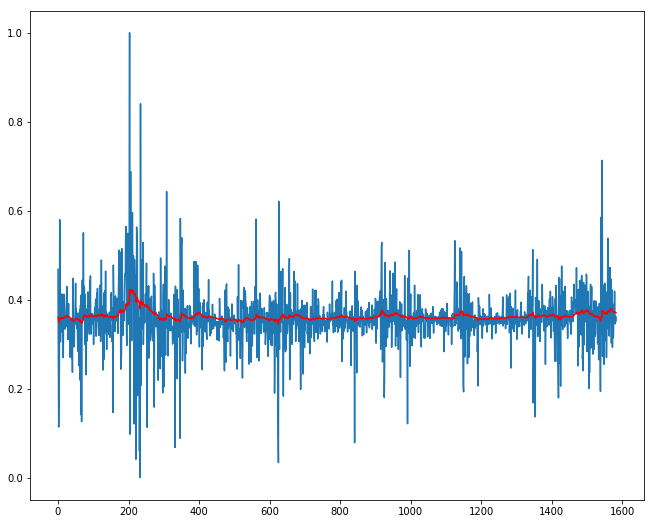

In [318]:
plt.plot(train)
plt.plot(y_hat, c = 'red')
plt.show()

In [18]:
#gjr garch
am = arch_model(train, p=1, o=1, q=2)
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                      y   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                  GJR-GARCH   Log-Likelihood:                2414.57
Distribution:                  Normal   AIC:                          -4817.13
Method:            Maximum Likelihood   BIC:                          -4784.93
                                        No. Observations:                 1583
Date:                Tue, Dec 18 2018   Df Residuals:                     1577
Time:                        22:30:50   Df Model:                            6
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3551  1.188e-03    298.946      0.000 [  0.353,  0.35

In [41]:
model_fit = am.fit()
# forecast the test set
forecasts = model_fit.forecast(horizon=split_value_ratio)
#[split_value_ratio:]
y_hat = forecasts.mean

Iteration:      1,   Func. Count:      8,   Neg. LLF: -2412.9430646471765
Iteration:      2,   Func. Count:     23,   Neg. LLF: -2414.507191894424
Iteration:      3,   Func. Count:     34,   Neg. LLF: -2414.5247680601733
Iteration:      4,   Func. Count:     48,   Neg. LLF: -2414.5651356069366
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2414.565124922732
            Iterations: 5
            Function evaluations: 57
            Gradient evaluations: 4


In [34]:
import matplotlib.pyplot as plt

In [ ]:
y_hat_gjr = 0.1 * np.sqrt(res.params['omega'] + (res.params['alpha[1]'] + res.params['gamma[1]']) * res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]'])

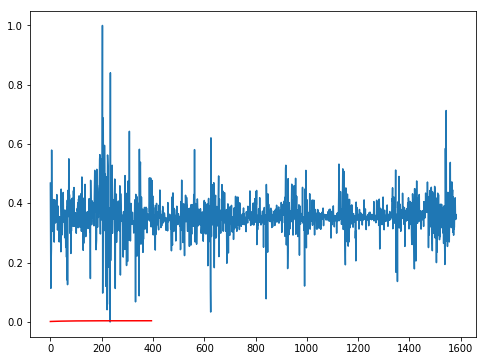

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(train)
plt.plot(y_hat.dropna().values[0], c = 'red')
plt.show()